# Capstone Project Notebook

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import folium
import config
import requests
from pandas.io.json import json_normalize

### Import Home Value Data
I downloaded and cleaned Zillow Home Value Index data for all of North Carolina and segmented out only the largest 150 zip codes in the state, figuring that the great majority of people live in those areas.

In [100]:
# Create dataframe from Zillow Home Value Index
df_data_1 = pd.read_csv('data/NC-ZHVI.csv')
df_data_1.head()

,ZipCode,City,SizeRank,2015,2015Weight,2016,2016Weight,2017,2017Weight,2018,2018Weight,2019,2019Weight
0,28269,Charlotte,1,161155,1,172662,2,189549,3,207802,4,222079,5
1,28277,Charlotte,2,300910,1,318152,2,339128,3,357253,4,366603,5
2,28027,Concord,3,196663,1,205240,2,222421,3,237999,4,250122,5
3,27587,Wake Forest,4,285567,1,295697,2,307897,3,319676,4,330524,5
4,28078,Huntersville,5,261813,1,276244,2,293663,3,309628,4,318790,5


### Calculate percent growth in home value since 2015 by zip code and add to dataframe:

In [137]:
percent_growth = round(100*((df_data_1["2019"] - df_data_1["2015"])/df_data_1["2015"]),2)

# Add percent growth to dataframe
df_data_1["Growth"] = percent_growth
df_data_1.head()

,ZipCode,City,SizeRank,2015,2015Weight,2016,2016Weight,2017,2017Weight,2018,2018Weight,2019,2019Weight,Growth
0,28269,Charlotte,1,161155,1,172662,2,189549,3,207802,4,222079,5,37.80
1,28277,Charlotte,2,300910,1,318152,2,339128,3,357253,4,366603,5,21.83
2,28027,Concord,3,196663,1,205240,2,222421,3,237999,4,250122,5,27.18
3,27587,Wake Forest,4,285567,1,295697,2,307897,3,319676,4,330524,5,15.74
4,28078,Huntersville,5,261813,1,276244,2,293663,3,309628,4,318790,5,21.76


Okay, so that is the growth from 2015-2019.

### Look for outliers to focus on

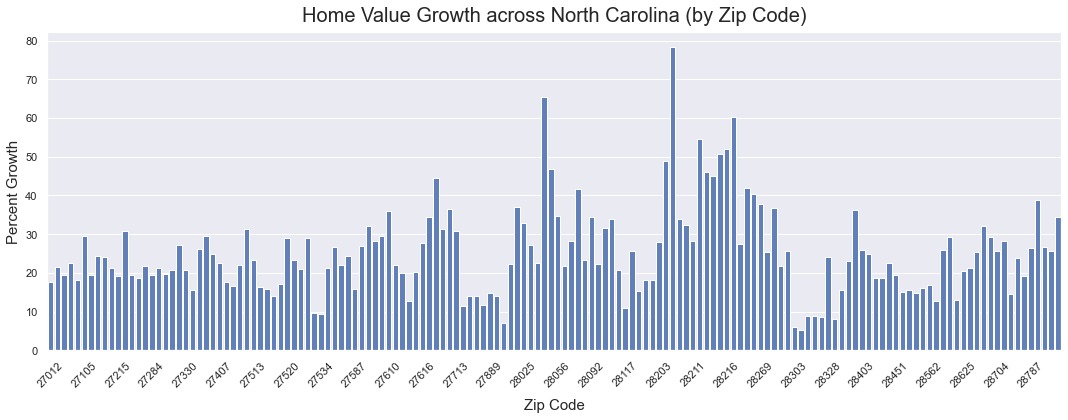

In [180]:
fig, ax = plt.subplots(figsize=(15,6))

ax = sns.barplot(x="ZipCode", y="Growth", data=df_data_1, label="Zip Code", color='#527bc6')
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::5]))
for label in temp:
    label.set_visible(False)
ax.set_title("Home Value Growth across North Carolina (by Zip Code)",fontsize=20, pad=10)
ax.set_xlabel("Zip Code",fontsize=15, labelpad=10)
ax.set_ylabel("Percent Growth",fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('images/home_value_growth_barplot.png')

plt.show()

From this we can see that almost everywhere has seen 15%-30% growth over the past 5 years.  There are 10-15 places that have seen over 40% growth.  We want to focus on them!

### Separate out the top values to focus on:

In [104]:
df_top_charlotte = df_data_1.sort_values(by='Growth', ascending=False)[0:5]
df_top_charlotte

,ZipCode,City,SizeRank,2015,2015Weight,2016,2016Weight,2017,2017Weight,2018,2018Weight,2019,2019Weight,Growth
81,28208,Charlotte,82,83099,1,93417,2,111611,3,131912,4,148220,5,78.37
102,28052,Gastonia,103,71351,1,76418,2,88737,3,101775,4,117987,5,65.36
131,28217,Charlotte,132,96948,1,106697,2,121787,3,141973,4,155477,5,60.37
68,28212,Charlotte,69,121155,1,131807,2,149064,3,171456,4,187153,5,54.47
19,28216,Charlotte,20,122057,1,135649,2,152232,3,169632,4,185619,5,52.08


So, it looks like four out of the top 5 growing zip codes are located in the Charlotte, NC area.  Let's focus on them.  Let's filter out that Gastonia zip code:

In [105]:
# Filter only Charlotte zip codes
df_top_charlotte = df_top_charlotte[df_top_charlotte["City"] == "Charlotte"]

# Rename zip code column
df_top_charlotte = df_top_charlotte.rename(columns={"ZipCode": "zipcode"})
df_top_charlotte

,zipcode,City,SizeRank,2015,2015Weight,2016,2016Weight,2017,2017Weight,2018,2018Weight,2019,2019Weight,Growth
81,28208,Charlotte,82,83099,1,93417,2,111611,3,131912,4,148220,5,78.37
131,28217,Charlotte,132,96948,1,106697,2,121787,3,141973,4,155477,5,60.37
68,28212,Charlotte,69,121155,1,131807,2,149064,3,171456,4,187153,5,54.47
19,28216,Charlotte,20,122057,1,135649,2,152232,3,169632,4,185619,5,52.08


### Map the zip codes using Folium

In [106]:
# Create Map object
charlotte_map = folium.Map(location=[35.2271, -80.8431], zoom_start=10)

# Zip code boundaries from a JSON file
charlotte_geo = 'data/charlotte_top_zip_codes_json2.txt'

Lesson learned here!  Make sure that the data type of your key_on column matches the data type of the column it is connected to in your dataframe!  My zip codes were strings in the geojson file, and that took a while to fix.

In [107]:
charlotte_map = folium.Map(location=[35.2271, -80.8431], zoom_start=11)

folium.Choropleth(
    geo_data=charlotte_geo,
    data=df_top_charlotte,
    columns=['zipcode', 'Growth'],
    key_on='feature.properties.zipcode',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Growth in Charlotte",
    highlight=True
).add_to(charlotte_map)

charlotte_map

### Query data from the Foursquare API
First we will save the client query info to Python objects:

In [108]:
client_id = config.client_id
client_secret = config.client_secret
radius = 13680 #This is an 8.5-mile radius to stay outside of central Charlotte
radius2 = 5632 #3.5-mile radius
radius3 = 4828 #3-mile radius
venue_count = 150
section = 'food'
version = '20200331'

# First area of Charlotte
charlotte_lat = 35.320981
charlotte_lon = -80.944489

# Second area of Charlotte
charlotte_lat2 = 35.164533
charlotte_lon2 = -80.936224

# Third area of Charlotte
charlotte_lat3 = 35.203451
charlotte_lon3 = -80.741009

In [109]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
    client_id, 
    client_secret, 
    version, 
    charlotte_lat, 
    charlotte_lon, 
    radius, 
    venue_count,
    section)

url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
    client_id, 
    client_secret, 
    version, 
    charlotte_lat2, 
    charlotte_lon2, 
    radius2, 
    venue_count,
    section)

url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
    client_id, 
    client_secret, 
    version, 
    charlotte_lat3, 
    charlotte_lon3, 
    radius3, 
    venue_count,
    section)

In [110]:
# Requests to the FourSquare API
results = requests.get(url).json()

results2 = requests.get(url2).json()

results3 = requests.get(url3).json()

In [111]:
# Function that extracts the category of the venue
# I got this function from a class exercise
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [112]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\ericd\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Chick-fil-A,Fast Food Restaurant,35.326858,-80.944759
1,Shuffletown Drive-in,Breakfast Spot,35.321630,-80.952922
2,Heirloom,Southern / Soul Food Restaurant,35.305047,-80.937486
3,Lancaster's BBQ,BBQ Joint,35.351433,-80.888279
4,Tony's Pizza,Pizza Place,35.357312,-80.868105


In [113]:
venues2 = results2['response']['groups'][0]['items']
    
nearby_venues2 = json_normalize(venues2) # flatten JSON

# filter columns
filtered_columns2 = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues2 =nearby_venues2.loc[:, filtered_columns2]

# filter the category for each row
nearby_venues2['venue.categories'] = nearby_venues2.apply(get_category_type, axis=1)

# clean columns
nearby_venues2.columns = [col.split(".")[-1] for col in nearby_venues2.columns]

nearby_venues2.head()

C:\Users\ericd\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Zaxby's Chicken Fingers & Buffalo Wings,Fried Chicken Joint,35.150300,-80.925411
1,Firehouse Subs,Sandwich Place,35.139710,-80.934993
2,Dragon Buffet,Chinese Restaurant,35.145576,-80.936407
3,Nana's Soul Food Kitchen,Southern / Soul Food Restaurant,35.190075,-80.921903
4,Mac's Speed Shop,BBQ Joint,35.135853,-80.940074


In [114]:
venues3 = results3['response']['groups'][0]['items']
    
nearby_venues3 = json_normalize(venues3) # flatten JSON

# filter columns
filtered_columns3 = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues3 =nearby_venues3.loc[:, filtered_columns3]

# filter the category for each row
nearby_venues3['venue.categories'] = nearby_venues3.apply(get_category_type, axis=1)

# clean columns
nearby_venues3.columns = [col.split(".")[-1] for col in nearby_venues3.columns]

nearby_venues3.head()

C:\Users\ericd\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Cook-Out,Burger Joint,35.202062,-80.734876
1,Pho an Hoa,Vietnamese Restaurant,35.211579,-80.761481
2,Island Grocery Caribbean Restaurant,Caribbean Restaurant,35.203821,-80.746209
3,Al-Basha,Mediterranean Restaurant,35.203522,-80.760600
4,Popeyes Louisiana Kitchen,Fried Chicken Joint,35.203651,-80.743059


In [115]:
print('{} venues were returned by Foursquare for west Charlotte.'.format(nearby_venues.shape[0]))
print('{} venues were returned by Foursquare for southwest Charlotte.'.format(nearby_venues2.shape[0]))
print('{} venues were returned by Foursquare for southeast Charlotte.'.format(nearby_venues3.shape[0]))

100 venues were returned by Foursquare for west Charlotte.
100 venues were returned by Foursquare for southwest Charlotte.
100 venues were returned by Foursquare for southeast Charlotte.


## Concatenate all three venues dataframes and remove duplicates

In [184]:
all_dataframes = [nearby_venues, nearby_venues2, nearby_venues3]

all_venues = pd.concat(all_dataframes)
og_count = all_venues.shape[0]

# Drop duplicates
all_venues.drop_duplicates(keep=False, inplace=True)
new_count = all_venues.shape[0]

print('There were', og_count-new_count, 'duplicates in the dataset.')

There were 2 duplicates in the dataset.


Looks like we only had two duplicates.  Great!

In [120]:
all_venues.head()

,name,categories,lat,lng
0,Chick-fil-A,Fast Food Restaurant,35.326858,-80.944759
1,Shuffletown Drive-in,Breakfast Spot,35.321630,-80.952922
2,Heirloom,Southern / Soul Food Restaurant,35.305047,-80.937486
3,Lancaster's BBQ,BBQ Joint,35.351433,-80.888279
4,Tony's Pizza,Pizza Place,35.357312,-80.868105


## Plot locations on choropleth map

In [122]:
charlotte_map = folium.Map(location=[35.2271, -80.8431], zoom_start=11)

folium.Choropleth(
    geo_data=charlotte_geo,
    data=df_top_charlotte,
    columns=['zipcode', 'Growth'],
    key_on='feature.properties.zipcode',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Growth in Charlotte",
    highlight=True
).add_to(charlotte_map)

for i in range(0,len(all_venues)):
    folium.CircleMarker(([all_venues.iloc[i]['lat'], all_venues.iloc[i]['lng']]), 
                        popup=all_venues.iloc[i]['name'], fill=True, 
                        fill_opacity=.3, 
                        # fill_color=nearby_venues.iloc[i]['Marker Color'], 
                        # color=nearby_venues.iloc[i]['Marker Color']
                        ).add_to(charlotte_map)

charlotte_map

## k-Means Clustering Analysis

Now that we have identified the zip codes of interest and pulled information about potential competition, it's time to cluster the competition to see if we can find spaces of opportunity.

### First, Elbow Plot to determine optimal cluster count

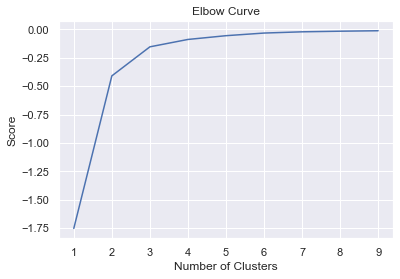

In [123]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
y_axis = all_venues[['lat']]
x_axis = all_venues[['lng']]
score = [kmeans[i].fit(y_axis).score(y_axis) for i in range(len(kmeans))]

# Graph out the scores by the number of clusters
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

This is actually much smaller than I expected, considering the wide spread of locations on the map above.  We're going to use our domain knowledge to trump what the elbow curve says and try a larger number of clusters.

### Now to actually determine the clusters...

In [124]:
kmeans = KMeans(n_clusters = 8, init = 'k-means++')  #Decided to go with 8 clusters
kmeans.fit(all_venues[all_venues.columns[3:5]])

all_venues["Cluster Assignment"] = kmeans.fit_predict(all_venues[all_venues.columns[3:5]])

In [125]:
all_venues.head()

,name,categories,lat,lng,Cluster Assignment
0,Chick-fil-A,Fast Food Restaurant,35.326858,-80.944759,1
1,Shuffletown Drive-in,Breakfast Spot,35.321630,-80.952922,6
2,Heirloom,Southern / Soul Food Restaurant,35.305047,-80.937486,1
3,Lancaster's BBQ,BBQ Joint,35.351433,-80.888279,2
4,Tony's Pizza,Pizza Place,35.357312,-80.868105,7


In [126]:
labels = all_venues["Cluster Assignment"]

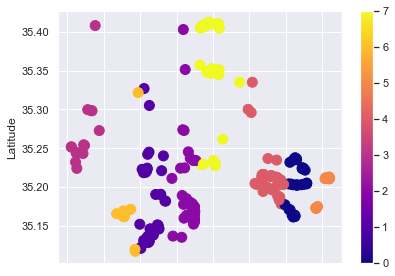

In [199]:
all_venues.plot.scatter(x = 'lng', y = 'lat', c=labels, s=100, cmap="plasma")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('images/cluster_map.png')

### Now to plot the clusters on Folium
First, we need to assign a color to each of the markers:

In [135]:
# Create array of cluster assignments
clusters = all_venues["Cluster Assignment"].to_numpy()

# Store colors in new list
marker_color = []
i=0

for number in clusters:
    if clusters[i] == 7:
        marker_color.append("red")
    elif clusters[i] == 6:
        marker_color.append("orange")
    elif clusters[i] == 5:
        marker_color.append("black")
    elif clusters[i] == 4:
        marker_color.append("green")
    elif clusters[i] == 3:
        marker_color.append("blue")
    elif clusters[i] == 2:
        marker_color.append("purple")
    elif clusters[i] == 1:
        marker_color.append("yellow")
    else:
        marker_color.append("pink")
    i+=1

# Add markers to the dataframe
all_venues["Marker Color"] = marker_color

## The Final Map!

In [136]:
charlotte_map = folium.Map(location=[35.2271, -80.8431], zoom_start=11)

folium.Choropleth(
    geo_data=charlotte_geo,
    data=df_top_charlotte,
    columns=['zipcode', 'Growth'],
    key_on='feature.properties.zipcode',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Growth in Charlotte",
    highlight=True
).add_to(charlotte_map)

for i in range(0,len(all_venues)):
    folium.CircleMarker(([all_venues.iloc[i]['lat'], all_venues.iloc[i]['lng']]), 
                        popup=all_venues.iloc[i]['name'], fill=True, 
                        fill_opacity=.3, 
                        fill_color=all_venues.iloc[i]['Marker Color'], 
                        color=all_venues.iloc[i]['Marker Color']
                        ).add_to(charlotte_map)

charlotte_map